## Table of content

* [1. Imports](#imports)
* [2. Open File](#open)
* [3. Find Board Books](#board)
* [4. Content Based Recommendation System: based on book description](#recom_desc)
    * [4.1. Clean and Lemmatize Book Description](#clean_desc)
    * [4.2 Recommendation System: based on book description](#function)
* [5. Content Based Recommendation System based on reviews](#reviews)
    * [5.1 Clean and Lemmatize Reviews](#clean_rev)
    * [5.2 Recommendation System: based on book reviews](#function_rev)


## 1. Imports <a class='anchor' id='imports'>

In [247]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import nltk

nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

# nltk.download('averaged_perceptron_tagger')

from nltk.corpus import wordnet
nltk.download('wordnet')

from gensim.parsing.preprocessing import remove_stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer

import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from matplotlib import pyplot
from gensim.models import KeyedVectors

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\somfl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\somfl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Open File <a class='anchor' id='open'>

In [135]:
path = 'C:\\Users\\somfl\\Documents\\GitHub\\Somayeh_Youssefi\\Book Recomendation System\\data_files\\CleanedBooks.csv'
df = pd.read_csv(path, sep=',')
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

,book_id,isbn,title,description,num_pages,authors,ratings_count,average_rating,image_url,url,similar_books,authors_names,genres,positive_review,negative_review
0,287141,1599150603,The Aeneid for Boys and Girls,"Relates in vigorous prose the tale of Aeneas, ...",162.0,"[{'author_id': '3041852', 'role': ''}]",46.0,4.13,https://s.gr-assets.com/assets/nophoto/book/11...,https://www.goodreads.com/book/show/287141.The...,[],['Alfred J. Church'],"{'history, historical fiction, biography': 9, ...","Once again, my kids loved this book about anci...",NaN
1,6066812,1934876569,All's Fairy in Love and War (Avalon: Web of Ma...,"To Kara's astonishment, she discovers that a p...",216.0,"[{'author_id': '19158', 'role': ''}]",98.0,4.22,https://images.gr-assets.com/books/1316637798m...,https://www.goodreads.com/book/show/6066812-al...,"['948696', '439885', '274955', '12978730', '37...",['Rachel Roberts'],"{'fantasy, paranormal': 32, 'young-adult': 8, ...",NaN,"This was a really cute book, though to be hone..."
2,89378,0590417010,Dog Heaven,In Newbery Medalist Cynthia Rylant's classic b...,40.0,"[{'author_id': '5411', 'role': ''}]",1331.0,4.43,https://images.gr-assets.com/books/1360057676m...,https://www.goodreads.com/book/show/89378.Dog_...,"['834493', '452189', '140185', '1897316', '218...",['Cynthia Rylant'],"{'children': 109, 'fiction': 13, 'non-fiction'...","Really cute, sweet, and charming.,This beautif...",I probably would have liked this book more if ...
3,1698376,1416904999,What Do You Do?,WHAT DO YOU DO?\nA hen lays eggs...\nA cow giv...,24.0,"[{'author_id': '169159', 'role': ''}]",23.0,3.57,https://s.gr-assets.com/assets/nophoto/book/11...,https://www.goodreads.com/book/show/1698376.Wh...,[],['Mandy Stanley'],{'children': 6},NaN,Colourful. Fun to read. My daughter enjoys thi...
4,3631900,0884482987,Amadi's Snowman: A Story of Reading,When Amadi disobeys his mother and runs off to...,32.0,"[{'author_id': '1540277', 'role': ''}, {'autho...",44.0,3.89,https://images.gr-assets.com/books/1300370678m...,https://www.goodreads.com/book/show/3631900-am...,[],"['Katia Novet Saint-Lot', 'Dimitrea Tokunbo']","{'fiction': 6, 'children': 8, 'young-adult': 1}",My nine-year-old son and I enjoyed this book a...,"This is an enjoyable book, and Amadi is an eng..."


In [136]:
df.drop(index=21909, axis=0, inplace = True)
df = df.reset_index().drop(columns='index')

## 3. Find Board Books <a class='anchor' id='board'>

In [137]:
# Let's see how many board books we have:
board_book_list = []
for i in range(len(df)):
    text = df.loc[i, 'description'].lower()
    if ((re.search('board book', text)) or (re.search('sensory', text)) or (re.search('touch', text)) or (re.search('flap',text))):
        board_book_list.append(df.loc[i,'book_id'])
        

In [138]:
mask = df['book_id'].isin(board_book_list)
df_board_book = df[mask]
df_board_book.head()

,book_id,isbn,title,description,num_pages,authors,ratings_count,average_rating,image_url,url,similar_books,authors_names,genres,positive_review,negative_review
25,12291714,0545307406,We Belong Together,Because some things are just better together.\...,14.0,"[{'author_id': '2853809', 'role': ''}]",260.0,4.29,https://images.gr-assets.com/books/1328836198m...,https://www.goodreads.com/book/show/12291714-w...,"['13091239', '17290288', '13071808', '9617764'...",['Joyce Wan'],"{'children': 38, 'young-adult': 3}",I can't get over how happy this book made me. ...,"Sweetly illustrated, this book shows pairs of ..."
84,27170668,1465450718,Baby Touch Your Nose,Where's baby's nose? There it is! Baby Touch Y...,14.0,"[{'author_id': '85770', 'role': ''}]",11.0,4.00,https://images.gr-assets.com/books/1456092366m...,https://www.goodreads.com/book/show/27170668-b...,[],['Dawn Sirett'],{'children': 2},NaN,Interactive book for baby about where their bo...
105,22581552,1783931531,Touch and Feel Baby Animals,"Touch and Feel Baby Animals, a tactile board b...",12.0,"[{'author_id': '255639', 'role': ''}]",13.0,4.08,https://images.gr-assets.com/books/1404476928m...,https://www.goodreads.com/book/show/22581552-t...,[],['Make Believe Ideas'],{'children': 2},"In this baby book, little readers interact wit...",NaN
120,10518542,1561486892,"What Will Happen to Me: Every Night, Approxima...",What is life like for a child who has a parent...,94.0,"[{'author_id': '74938', 'role': ''}]",19.0,4.16,https://images.gr-assets.com/books/1369086005m...,https://www.goodreads.com/book/show/10518542-w...,[],['Howard Zehr'],"{'non-fiction': 3, 'children': 2, 'young-adult...",This book talks about the challenges that chil...,NaN
132,2974706,1851520198,The Arthur Rackham Fairy Book,"""Old Tales with New Ilustrations"" was how this...",271.0,"[{'author_id': '69163', 'role': ''}]",10.0,4.38,https://s.gr-assets.com/assets/nophoto/book/11...,https://www.goodreads.com/book/show/2974706-th...,[],['Arthur Rackham'],"{'fiction': 9, 'fantasy, paranormal': 6, 'chil...",This is as good as it gets! The illustrations ...,NaN


In [139]:
# Let's check to see if there is any duplicates
df_board_book.duplicated(subset='title').sum()

232

In [142]:
df_board_book.drop_duplicates(subset=['title'], inplace = True)

In [ ]:
# Let's check for empty reviews

In [157]:
df_board_book.isna().sum()

book_id               0
isbn                 97
title                 0
description           0
num_pages             0
authors               0
ratings_count         0
average_rating        0
image_url             0
url                   0
similar_books         0
authors_names         0
genres                0
positive_review     449
negative_review    1136
clean_desc            0
lem_clean_desc        0
dtype: int64

In [162]:
# Drop empty reviews
df_board_book.dropna(subset=['positive_review', 'negative_review'], inplace=True)
# Let's reset the index
df_board_book= df_board_book.reset_index().drop(columns='index')

In [163]:
df_board_book.shape

(1040, 17)

In [164]:
df_board_book.isna().sum()

book_id             0
isbn               24
title               0
description         0
num_pages           0
authors             0
ratings_count       0
average_rating      0
image_url           0
url                 0
similar_books       0
authors_names       0
genres              0
positive_review     0
negative_review     0
clean_desc          0
lem_clean_desc      0
dtype: int64

## 4. Content Based Recommendation System: based on book description <a class='anchor' id='recom_desc'>

### 4.1. Clean and Lemmatize Book Description <a class='anchor' id='clean_desc'>

In [255]:
# Let's define a function to clean the text

def clean_function (text):

    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    # remove non-ASCII characheters
    
    text = "".join(i for i in text if  ord(i)<128)
    
    # change to lower case
    text = text.lower()

    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    contractions = { 
    "ain't": "am not","aint": "am not",
    "aren't": "are not","arent": "are not",
    "can't": "cannot","cant": "cannot",
    "can't've": "cannot have","cant've": "cannot have",
    "'cause": "because",
    "could've": "could have","couldve": "could have",
    "couldn't": "could not","couldnt": "could not",
    "couldn't've": "could not have","couldnt've": "could not have",
    "didn't": "did not","didnt": "did not",
    "doesn't": "does not","doesnt": "does not",
    "don't": "do not","dont": "do not",
    "hadn't": "had not","hadnt": "had not",
    "hadn't've": "had not have","hadnt've": "had not have",
    "hasn't": "has not","hasnt": "has not",
    "haven't": "have not","havent": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would","id": "i would",
    "i'll": "i will",
    "i'm": "i am","im": "i am",
    "i've": "i have","ive": "i have",
    "isn't": "is not","isnt": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "must've": "must have",
    "mustn't": "must not","mustnt": "must not",
    "needn't": "need not",
    "oughtn't": "ought not",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that'd": "that would",
    "that's": "that is","thats": "that is",
    "there'd": "there had",
    "there's": "there is","theres": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "where'd": "where did",
    "where's": "where is",
    "who'll": "who will",
    "who's": "who is",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are"
    }
    

    text = word_tokenize(text)
    # Replace contractions with their longer forms 
    new_text = []
    for word in text:
        if word in contractions:
            new_text.append(contractions[word])
        else:
            new_text.append(word)
    text = " ".join(new_text)
        
    # Removing english stopwords 
    text = remove_stopwords(text)
    


    return text

In [275]:
# Lemmatize and stemming

def preprocess(text):
    text = word_tokenize(text)
    result = []
    for word in text:

        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        lemm = nltk.stem.WordNetLemmatizer().lemmatize(word, tag_dict.get(tag, wordnet.NOUN))
        
        stemmer = SnowballStemmer('english')
        stemm = stemmer.stem(lemm)
        result.append(stemm)
    result = " ".join(result)
    return result
        

In [276]:
# Let's clean and lemmatize description

df_board_book['clean_desc'] = df_board_book['description'].apply(clean_function)
df_board_book['lem_clean_desc'] = df_board_book['clean_desc'].apply(preprocess)

### 4.2 Recommendation System: based on book description <a class='anchor' id='function'>

In [277]:
# Function for recommending books based on Book description. It takes book title as input:
def recomm_title(book_title):

    indx = pd.Series(df_board_book.index, index = df_board_book['title'])

    #Converting the book discription into vectors
    tfModel = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), min_df = 1, stop_words='english')
    tfidf_vector = tfModel.fit_transform(df_board_book['lem_clean_desc'])
    
    # Estimate the similarity of book description based on Cosine Similarity
    similarity_matrix = cosine_similarity(tfidf_vector, tfidf_vector)
    
    # Get the index corresponding to original_title
       
    idx = indx[book_title]# Get the pairwsie similarity scores 
    similar_books = sorted(list(enumerate(similarity_matrix[idx])), key=lambda x: x[1], reverse=True)
    Top_five_similar_books = similar_books[1:6]# Book indicies
    book_indices = [i[0] for i in Top_five_similar_books]
   
    # Top 10 book recommendation
    recommendation = df_board_book[['title', 'authors_names']].iloc[book_indices]
       
    # It reads the top 5 recommended book urls and print the images
    

    return recommendation

In [278]:
recomm_title('Dear Zoo: A Lift-the-Flap Book')

,title,authors_names
377,History Of Pets And People,"['Sheila Keenan', 'Kate Waters']"
775,Touch and Feel: Pets,['Nicola Deschamps']
1008,How to Raise a Dinosaur,"['Natasha Wing', 'Pablo Bernasconi']"
725,Pat the Zoo,"['Golden Books', 'LV Studio']"
140,"Can You Say It, Too? Roar! Roar!","['Nosy Crow', 'Sebastien Braun']"


## 5. Content Based Recommendation System based on book reviews <a class='anchor' id='reviews'>

### 5.1 Clean and Lemmatize Reviews <a class='anchor' id='clean_rev'>

In [282]:
# Let's clean and lemmatize positive review

df_board_book['clean_positive'] = df_board_book['positive_review'].apply(clean_function)
df_board_book['lem_clean_positive'] = df_board_book['clean_positive'].apply(preprocess)

### 5.2 Recommendation System: based on book reviews <a class='anchor' id='function_rev'>

In [283]:
def recomm_title_rev(book_title):

    indx = pd.Series(df_board_book.index, index = df_board_book['title'])

    #Converting the book discription into vectors
    tfModel = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), min_df = 1, stop_words='english')
    tfidf_vector = tfModel.fit_transform(df_board_book['lem_clean_positive'])
    
    # Estimate the similarity of book description based on Cosine Similarity
    similarity_matrix = cosine_similarity(tfidf_vector, tfidf_vector)
    
    # Get the index corresponding to original_title
       
    idx = indx[book_title]# Get the pairwsie similarity scores 
    similar_books = sorted(list(enumerate(similarity_matrix[idx])), key=lambda x: x[1], reverse=True)
    Top_five_similar_books = similar_books[1:6]# Book indicies
    book_indices = [i[0] for i in Top_five_similar_books]
   
    # Top 10 book recommendation
    recommendation = df_board_book[['title', 'authors_names', 'book_id']].iloc[book_indices]
       
    # It reads the top 5 recommended book urls and print the images
    

    return recommendation

In [284]:
recomm_title_rev('Dear Zoo: A Lift-the-Flap Book')

,title,authors_names,book_id
140,"Can You Say It, Too? Roar! Roar!","['Nosy Crow', 'Sebastien Braun']",20708832
611,Do Crocs Kiss?,['Salina Yoon'],13584655
862,Where Is Baby's Belly Button?,['Karen Katz'],827501
64,"Good Night, Gorilla",['Peggy Rathmann'],773276
397,"Can You Say It, Too? Quack! Quack!","['Nosy Crow', 'Sebastien Braun']",22747852


In [156]:
df_board_book.loc[df_board_book['book_id']==809849]

,book_id,isbn,title,description,num_pages,authors,ratings_count,average_rating,image_url,url,similar_books,authors_names,genres,positive_review,negative_review,clean_desc,lem_clean_desc
2124,809849,141694737X,Dear Zoo: A Lift-the-Flap Book,A child writes to the zoo for a pet. The zoo s...,18.0,"[{'author_id': '216562', 'role': ''}]",17094.0,4.25,https://images.gr-assets.com/books/1391337388m...,https://www.goodreads.com/book/show/809849.Dea...,"['378164', '391028', '132609', '1153709', '563...",['Rod Campbell'],"{'children': 628, 'fiction': 41}",One of many books I was far too old to read bu...,"Great for Zoo storytime!,A lift-the-flap book....",child writes zoo pet zoo send series unsuitabl...,child writes zoo pet zoo send series unsuitabl...


## Topic extraction

In [352]:
# Let's clean and lemmatize negative reviews

df_board_book['clean_negative'] = df_board_book['negative_review'].apply(clean_function)
df_board_book['lem_clean_neg'] = df_board_book['clean_negative'].apply(preprocess)

In [385]:
doc = [df_board_book.loc[i, 'lem_clean_neg'] for i in range(len(df_board_book))]

In [386]:
len(doc)

1040

In [388]:
dataset = [d.split() for d in doc]

In [378]:
def LDA_initialize(doc):
    dictionary = gensim.corpora.Dictionary(doc)
    print("Number of words:", len(dictionary))
    dictionary.filter_extremes(no_below=15, no_above=0.60)
    print("Number of words after filtering:", len(dictionary))
    
    print("Creating Corpus...")
    bow_corpus = [dictionary.doc2bow(text) for text in doc]
    
    return dictionary, bow_corpus


In [389]:
dictionary, bow_corpus = LDA_initialize(dataset)


Number of words: 10718
Number of words after filtering: 948
Creating Corpus...


In [390]:
example = bow_corpus[20]

for i in range(len(example)):
    print("Word {} (\"{}\") appears {} time.".format(example[i][0], 
                                                     dictionary[example[i][0]], 
                                                     example[i][1]))

Word 120 ("love") appears 1 time.
Word 191 ("look") appears 1 time.
Word 326 ("flap") appears 1 time.
Word 327 ("lift") appears 1 time.
Word 562 ("son") appears 1 time.


## TF-IDF (Term Frequency-Inverse Document Frequency)

TF-IDF is a statistical measure that is used to evaluate the importance of a given word to a document in a corpus. A word is more important if the number of times a word appears in the document increases but deemed less important if it has a high frequency of appearing in the corpus. We can use this metric in conjuction with the LDA bag of words dictionary.



In [391]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

  0%|          | 0/18 [00:00<?, ?it/s]

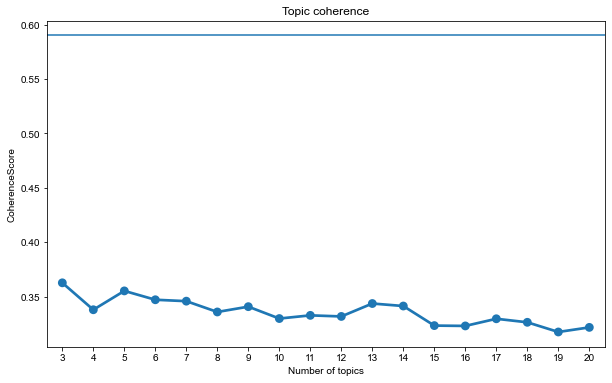

In [395]:
import seaborn as sns
Lda = models.LdaMulticore
coherenceList_umass = []
coherenceList_cv = []
num_topics_list = np.arange(3,21)
for num_topics in tqdm(num_topics_list):
    lda= Lda(bow_corpus, num_topics=num_topics,id2word = dictionary, 
             passes=20,chunksize=4000,random_state=43)
    cm = CoherenceModel(model=lda, corpus=bow_corpus, 
                        dictionary=dictionary, coherence='u_mass')
    coherenceList_umass.append(cm.get_coherence())
    cm_cv = CoherenceModel(model=lda, corpus=bow_corpus,
                           texts=dataset, dictionary=dictionary, coherence='c_v')
    coherenceList_cv.append(cm_cv.get_coherence())

plotData = pd.DataFrame({'Number of topics':num_topics_list,
                         'CoherenceScore':coherenceList_cv})
f,ax = plt.subplots(figsize=(10,6))
sns.set_style("whitegrid")
sns.pointplot(x='Number of topics',y= 'CoherenceScore',data=plotData)
plt.axhline(y=0.59)
plt.title('Topic coherence')
plt.savefig('Topic coherence plot.png')

In [396]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, 
                                             num_topics=10, 
                                             id2word=dictionary, 
                                             passes=20,
                                             chunksize=4000,
                                             workers=4,
                                             random_state=41)

lda_model_tfidf.save('lda_model_tfidf')
dictionary.save('dictionary')
corpora.MmCorpus.serialize('corpus_tfidf.mm', corpus_tfidf)

In [397]:
Lda = models.LdaMulticore
lda=Lda.load('lda_model_tfidf')
dictionary = corpora.Dictionary.load('dictionary')
corpus_tfidf = corpora.MmCorpus('corpus_tfidf.mm')

lda.show_topics()

[(0,
  '0.055*"sm" + 0.011*"peopl" + 0.009*"point" + 0.007*"exact" + 0.007*"import" + 0.007*"discov" + 0.006*"moral" + 0.006*"pop" + 0.005*"toddler" + 0.005*"trip"'),
 (1,
  '0.039*"poem" + 0.030*"e" + 0.018*"dog" + 0.018*"cute" + 0.016*"great" + 0.011*"babi" + 0.009*"fun" + 0.008*"make" + 0.008*"relat" + 0.008*"night"'),
 (2,
  '0.026*"flap" + 0.025*"duck" + 0.022*"lift" + 0.021*"jack" + 0.018*"o" + 0.014*"win" + 0.011*"ador" + 0.010*"nose" + 0.010*"cute" + 0.008*"tri"'),
 (3,
  '0.018*"dinosaur" + 0.012*"excit" + 0.011*"white" + 0.010*"unfortun" + 0.009*"strong" + 0.009*"slight" + 0.009*"joke" + 0.009*"bulli" + 0.009*"l" + 0.009*"textur"'),
 (4,
  '0.021*"vocabulari" + 0.018*"review" + 0.014*"love" + 0.012*"tub" + 0.011*"r" + 0.009*"cool" + 0.008*"pet" + 0.008*"flap" + 0.008*"cute" + 0.008*"kind"'),
 (5,
  '0.015*"ll" + 0.013*"super" + 0.011*"pig" + 0.011*"cute" + 0.010*"touch" + 0.008*"buy" + 0.006*"girl" + 0.006*"label" + 0.006*"artist" + 0.006*"illustr"'),
 (6,
  '0.023*"board" + 

In [398]:
doc2 = [df_board_book.loc[i, 'lem_clean_desc'] for i in range(len(df_board_book))]
dataset2 = [d.split() for d in doc]
dictionary, bow_corpus = LDA_initialize(dataset2)


Number of words: 10718
Number of words after filtering: 948
Creating Corpus...


In [399]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

  0%|          | 0/18 [00:00<?, ?it/s]

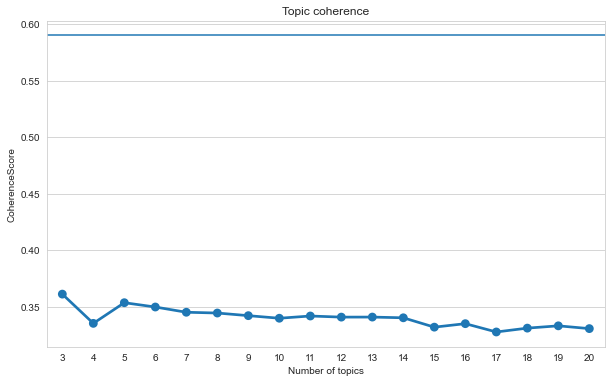

In [402]:
Lda = models.LdaMulticore
coherenceList_umass = []
coherenceList_cv = []
num_topics_list = np.arange(3,21)
for num_topics in tqdm(num_topics_list):
    lda= Lda(bow_corpus, num_topics=num_topics,id2word = dictionary, 
             passes=5,chunksize=500,random_state=43)
    cm = CoherenceModel(model=lda, corpus=bow_corpus, 
                        dictionary=dictionary, coherence='u_mass')
    coherenceList_umass.append(cm.get_coherence())
    cm_cv = CoherenceModel(model=lda, corpus=bow_corpus,
                           texts=dataset2, dictionary=dictionary, coherence='c_v')
    coherenceList_cv.append(cm_cv.get_coherence())

plotData = pd.DataFrame({'Number of topics':num_topics_list,
                         'CoherenceScore':coherenceList_cv})
f,ax = plt.subplots(figsize=(10,6))
sns.set_style("whitegrid")
sns.pointplot(x='Number of topics',y= 'CoherenceScore',data=plotData)
plt.axhline(y=0.59)
plt.title('Topic coherence')
plt.savefig('Topic coherence plot.png')

In [411]:
from gensim import corpora, models

text = [df_board_book.loc[i, 'lem_clean_desc'] for i in range(len(df_board_book))]
docs = [d.split() for d in text]
dictionary_LDA = corpora.Dictionary(docs)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(doc) for doc in docs]

num_topics = 5
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=3, alpha=[0.1]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

Wall time: 4.9 s


In [412]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=10):
    print(str(i)+": "+ topic)
    print()

0: 0.012*"touch" + 0.011*"stori" + 0.011*"child" + 0.009*"new" + 0.007*"life" + 0.007*"t" + 0.007*"school" + 0.006*"young" + 0.006*"reader" + 0.006*"write"

1: 0.019*"new" + 0.014*"child" + 0.010*"board" + 0.009*"stori" + 0.009*"illustr" + 0.008*"touch" + 0.008*"reader" + 0.008*"color" + 0.007*"featur" + 0.007*"young"

2: 0.010*"flap" + 0.010*"love" + 0.009*"littl" + 0.009*"friend" + 0.009*"child" + 0.008*"touch" + 0.008*"illustr" + 0.007*"board" + 0.007*"anim" + 0.007*"perfect"

3: 0.012*"littl" + 0.012*"board" + 0.011*"stori" + 0.010*"child" + 0.008*"touch" + 0.008*"illustr" + 0.008*"young" + 0.008*"love" + 0.007*"play" + 0.007*"way"

4: 0.014*"touch" + 0.013*"babi" + 0.013*"child" + 0.013*"stori" + 0.010*"love" + 0.010*"littl" + 0.008*"board" + 0.008*"illustr" + 0.007*"friend" + 0.007*"life"



In [336]:
len(doc)

1040

In [413]:
tfModel = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), min_df = 1)
vector = tfModel.fit_transform(df_board_book['lem_clean_neg'])
data_dtm = pd.DataFrame(vector.toarray(), columns=tfModel.get_feature_names())
data_dtm_copy = data_dtm
word_df = pd.DataFrame(data_dtm.sum())
word_df = word_df.sort_values(by = 0, ascending = False)
print(word_df.shape)


(10668, 1)


In [416]:
from nltk import word_tokenize, pos_tag
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
# Let's create a function to pull out nouns from a string of text
def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

def adj(text):
    '''Given a string of text, tokenize the text and pull out only the  adjectives.'''
    is_adj = lambda pos: pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    adj = [word for (word, pos) in pos_tag(tokenized) if is_adj(pos)] 
    return ' '.join(adj)

def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [417]:
# noun filter on df
data_nouns = pd.DataFrame(df_board_book['lem_clean_neg'].apply(nouns))
data_nouns

# adjective filter on df
data_adj = pd.DataFrame(df_board_book['lem_clean_neg'].apply(adj))
data_adj

# noun adj filter on df
data_nouns_adj = pd.DataFrame(df_board_book['lem_clean_neg'].apply(nouns_adj))
data_nouns_adj

,lem_clean_neg
0,sweet illustr book show pair inanim object smi...
1,noteworthi book child adapt disney film contai...
2,abl time mem fox repetiti cover ador babi anim...
3,cute stori littl boat look child belov toy han...
4,bad ann gilbert actual friend rub fist heart p...
...,...
1035,artwork fine info interest math compon appeal ...
1036,book kid illustr event clear pidgen lithuanian...
1037,beauti paterson child dull book good speech li...
1038,audienc preschool illustr trippi bird plot rev...


In [419]:
tv_noun = TfidfVectorizer(stop_words='english', ngram_range = (1,2), max_df = .6, min_df = .01)
data_tv_noun = tv_noun.fit_transform(data_nouns.lem_clean_neg)
data_dtm_noun = pd.DataFrame(data_tv_noun.toarray(), columns=tv_noun.get_feature_names())
data_dtm_noun.index = data_nouns.index
data_dtm_noun

,abl,absolut,access,accompani,act,action,activ,add,addit,address,...,wouldn,wow,write,writer,year,year book,yes,york,youngster,youth
0,0.0,0.0,0.0,0.0,0.000000,0.111612,0.0,0.0,0.000000,0.0,...,0.122278,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.107842,0.0,...,0.000000,0.0,0.10725,0.0,0.071542,0.133307,0.0,0.138655,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.00000,0.0,0.157303,0.000000,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.375175,0.0,...,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
1036,0.0,0.0,0.0,0.0,0.133889,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
1037,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
1038,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0


In [425]:
from sklearn.decomposition import NMF

nmf_model = NMF(4)
doc_topic = nmf_model.fit_transform(data_tv_noun)

display_topics(nmf_model, tv_noun.get_feature_names(), 10)


Topic  0
stori, child, time, kid, thing, charact, girl, way, end, year

Topic  1
board book, board, toddler, babi, word, count, reader, simpl, page, love

Topic  2
flap, lift, lift flap, flap book, fun, anim, spot, lift book, look, coupl

Topic  3
illustr, cute, pictur, page, color, babi, anim, rhyme, child, pictur book


In [429]:
H_noun = pd.DataFrame(doc_topic.round(5),
             index = df_board_book['title'],
             columns = [0,1,2,3])

H_noun.head(10)

,0,1,2,3
title,,,,
We Belong Together,0.05389,0.08456,0.00935,0.05365
Old Yeller,0.13653,0.00000,0.00143,0.04600
Tuck Me In!,0.02224,0.01314,0.02700,0.20001
Toy Boat,0.05529,0.00000,0.00000,0.10766
"Anne of Avonlea (Anne of Green Gables, #2)",0.10954,0.00000,0.00933,0.01184
I'd Choose You,0.00000,0.00000,0.00000,0.00000
The Littlest Family's Big Day,0.07811,0.00867,0.00560,0.09214
The Alphabet Room,0.05010,0.00607,0.02288,0.06175
Mama's Right Here,0.04348,0.06443,0.00000,0.12716


In [430]:
tv = TfidfVectorizer(stop_words='english', ngram_range = (1,2), max_df = .6, min_df = .01)
data_tv_nadj= tv.fit_transform(data_nouns_adj.lem_clean_neg)
data_dtm_nadj = pd.DataFrame(data_tv_nadj.toarray(), columns=tv.get_feature_names())
data_dtm_nadj.index = data_nouns_adj.index
data_dtm_nadj

,abl,absolut,access,accompani,accur,act,action,activ,actual,adapt,...,yes,york,young,young boy,young child,young girl,young kid,young reader,youngster,youth
0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.095554,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0
1,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.101741,...,0.0,0.104519,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0
2,0.18498,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0
3,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0
4,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.067012,0.000000,...,0.0,0.000000,0.050159,0.0,0.077382,0.0,0.0,0.00000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.132367,0.0,0.000000,0.0,0.0,0.19919,0.0,0.0
1036,0.00000,0.0,0.0,0.0,0.0,0.115182,0.000000,0.0,0.079644,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0
1037,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0
1038,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0


In [432]:
nmf_model_adj_noun = NMF(4)
doc_topic_adj_noun = nmf_model_adj_noun.fit_transform(data_tv_nadj)

display_topics(nmf_model_adj_noun, tv.get_feature_names(), 10)


Topic  0
stori, child, good, charact, read, time, kid, girl, old, littl

Topic  1
board book, board, babi, count, word, toddler, simpl, page, reader, love

Topic  2
flap, lift, lift flap, flap book, fun, spot, anim, littl, open, cute

Topic  3
illustr, cute, anim, pictur, rhyme, page, babi, color, child, great


In [433]:
H_nadj = pd.DataFrame(doc_topic_adj_noun.round(5),
             index = df_board_book['title'],
             columns = [0,1,2,3])

H_nadj.head(10)

,0,1,2,3
title,,,,
We Belong Together,0.05363,0.07767,0.00260,0.07829
Old Yeller,0.15214,0.00000,0.00120,0.01776
Tuck Me In!,0.01364,0.01334,0.03002,0.19313
Toy Boat,0.06313,0.00000,0.00000,0.08991
"Anne of Avonlea (Anne of Green Gables, #2)",0.11285,0.00392,0.01124,0.02044
I'd Choose You,0.00000,0.00000,0.00000,0.00000
The Littlest Family's Big Day,0.06517,0.01304,0.01190,0.09267
The Alphabet Room,0.03706,0.00654,0.01116,0.05815
Mama's Right Here,0.06866,0.05251,0.00000,0.08003


In [54]:
# Let's see how many kid books we have:
kid_book_list = []
for i in range(len(df)):
    text = df.loc[i, 'description'].lower()
    if (((re.search('board book', text)) or (re.search('sensory', text)) or (re.search('touch', text)) or
    (re.search('lift the flap',text)) or ((re.search('picture',text)) and (re.search('child', text))) or
    ((re.search('illustration',text)) and (re.search('child', text))) or (re.search('illustration',text)) and (re.search('kid', text))
       or (re.search('picture',text)) and (re.search('kid', text))) and (re.search('adults', text)==None)):
        kid_book_list.append(df.loc[i,'book_id'])
        

In [57]:
mask = df['book_id'].isin(kid_book_list)
df_kid_book = df[mask]
df_kid_book.head()

,book_id,isbn,title,description,num_pages,authors,ratings_count,average_rating,image_url,url,similar_books,authors_names,genres,positive_review,negative_review
15,14287192,1400320259,"Totally Awesome, Super-Cool Bible Stories as D...",Join Ned as he draws--and learns--his way thro...,240.0,"[{'author_id': '5989065', 'role': 'Creator'}]",12.0,4.00,https://images.gr-assets.com/books/1355064907m...,https://www.goodreads.com/book/show/14287192-t...,[],['Corey Adams'],"{'children': 5, 'non-fiction': 1, 'young-adult...","Totally Awesome, Super-Cool Bible Stories as D...",Got this from NetGalley in exchange for a revi...
25,12291714,0545307406,We Belong Together,Because some things are just better together.\...,14.0,"[{'author_id': '2853809', 'role': ''}]",260.0,4.29,https://images.gr-assets.com/books/1328836198m...,https://www.goodreads.com/book/show/12291714-w...,"['13091239', '17290288', '13071808', '9617764'...",['Joyce Wan'],"{'children': 38, 'young-adult': 3}",I can't get over how happy this book made me. ...,"Sweetly illustrated, this book shows pairs of ..."
30,12403255,0733323359,Rudie Nudie,A delightful celebration of those nudie moment...,24.0,"[{'author_id': '2886984', 'role': 'Illustrator'}]",74.0,3.83,https://images.gr-assets.com/books/1404476568m...,https://www.goodreads.com/book/show/12403255-r...,[],['Emma Quay'],{'children': 8},On a scale of one to ten this scores a seventy...,Naked children on every page! Scandalous! Othe...
32,13594588,141970642X,"The Wimpy Kid Movie Diary, How Greg Heffley We...","If you've ever wondered how a movie gets made,...",256.0,"[{'author_id': '221559', 'role': ''}]",504.0,4.20,https://images.gr-assets.com/books/1412869093m...,https://www.goodreads.com/book/show/13594588-t...,"['18049049', '20893502', '20359711', '14891502...",['Jeff Kinney'],"{'non-fiction': 5, 'comics, graphic': 3, 'fict...",There's one more book! \n Having a wimpy kid b...,This for=kids book is a document of the making...
44,2161796,0375935347,Detective Camp (A to Z Mysteries: Super Editio...,"Dink, Josh, And Ruth Rose are back! This time,...",144.0,"[{'author_id': '1279057', 'role': ''}, {'autho...",935.0,4.17,https://images.gr-assets.com/books/1320453493m...,https://www.goodreads.com/book/show/2161796.De...,"['608375', '348565', '8108656', '32976', '8711...","['Ron Roy', 'John Steven Gurney']","{'mystery, thriller, crime': 22, 'fiction': 12...","Read this in 2nd grade,These are great seires ...",NaN


In [85]:
df_kid_book.dropna(subset=['positive_review', 'negative_review'])

,book_id,isbn,title,description,num_pages,authors,ratings_count,average_rating,image_url,url,similar_books,authors_names,genres,positive_review,negative_review
15,14287192,1400320259,"Totally Awesome, Super-Cool Bible Stories as D...",Join Ned as he draws--and learns--his way thro...,240.0,"[{'author_id': '5989065', 'role': 'Creator'}]",12.0,4.00,https://images.gr-assets.com/books/1355064907m...,https://www.goodreads.com/book/show/14287192-t...,[],['Corey Adams'],"{'children': 5, 'non-fiction': 1, 'young-adult...","Totally Awesome, Super-Cool Bible Stories as D...",Got this from NetGalley in exchange for a revi...
25,12291714,0545307406,We Belong Together,Because some things are just better together.\...,14.0,"[{'author_id': '2853809', 'role': ''}]",260.0,4.29,https://images.gr-assets.com/books/1328836198m...,https://www.goodreads.com/book/show/12291714-w...,"['13091239', '17290288', '13071808', '9617764'...",['Joyce Wan'],"{'children': 38, 'young-adult': 3}",I can't get over how happy this book made me. ...,"Sweetly illustrated, this book shows pairs of ..."
30,12403255,0733323359,Rudie Nudie,A delightful celebration of those nudie moment...,24.0,"[{'author_id': '2886984', 'role': 'Illustrator'}]",74.0,3.83,https://images.gr-assets.com/books/1404476568m...,https://www.goodreads.com/book/show/12403255-r...,[],['Emma Quay'],{'children': 8},On a scale of one to ten this scores a seventy...,Naked children on every page! Scandalous! Othe...
32,13594588,141970642X,"The Wimpy Kid Movie Diary, How Greg Heffley We...","If you've ever wondered how a movie gets made,...",256.0,"[{'author_id': '221559', 'role': ''}]",504.0,4.20,https://images.gr-assets.com/books/1412869093m...,https://www.goodreads.com/book/show/13594588-t...,"['18049049', '20893502', '20359711', '14891502...",['Jeff Kinney'],"{'non-fiction': 5, 'comics, graphic': 3, 'fict...",There's one more book! \n Having a wimpy kid b...,This for=kids book is a document of the making...
46,1038901,0152056580,Cook-a-Doodle-Doo!,Big Brown Rooster is sick of chicken feed. So ...,48.0,"[{'author_id': '22372', 'role': ''}, {'author_...",329.0,4.11,https://s.gr-assets.com/assets/nophoto/book/11...,https://www.goodreads.com/book/show/1038901.Co...,"['8137055', '72658', '6289810', '276937', '916...","['Janet Stevens', 'Susan Stevens Crummel']","{'children': 45, 'fantasy, paranormal': 2, 'yo...",This is a fun twist on the little-red-hen. Par...,"An old family recipe, four family friends, and..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59895,12118055,0545392152,"Good Night, I Love You",New from the bestselling illustrator of I Love...,20.0,"[{'author_id': '82741', 'role': ''}]",512.0,4.38,https://images.gr-assets.com/books/1328836562m...,https://www.goodreads.com/book/show/12118055-g...,"['6066270', '6557873', '3872116', '9617764', '...",['Caroline Jayne Church'],{'children': 37},I adore all the books by this author. They are...,One of the first books we ever read to our kid...
59902,2851,0525464824,The Invisible Child,"A new, peerless collection of speeches and ess...",266.0,"[{'author_id': '1949', 'role': ''}]",72.0,4.24,https://s.gr-assets.com/assets/nophoto/book/11...,https://www.goodreads.com/book/show/2851.The_I...,[],['Katherine Paterson'],"{'non-fiction': 9, 'children': 6, 'young-adult...","Very inspirational.,I couldn't put it down. wh...",This was really beautiful. I never read Paters...
59937,13429598,0547402066,Lots of Lambs,"""Happy lambs, / grumpy lambs, / Lambs in a coa...",20.0,"[{'author_id': '87184', 'role': ''}]",55.0,3.60,https://images.gr-assets.com/books/1344718858m...,https://www.goodreads.com/book/show/13429598-l...,[],['Laura Joffe Numeroff'],"{'children': 14, 'young-adult': 1, 'fiction': 1}",The publishing world excels at providing us wi...,This is an interactive book for young ones abo...
59943,22676115,1780674082,100 Great Children's Picturebooks,This unashamed visual feast celebrates the bes...,216.0,"[{'author_id': '493797', 'role': ''}]",